# Dynamic Refugee Matching - Simulations

This notebook replicates the simulations performed by Andersson, Ehlers and Martinello (2018). All the necessary documentation, requirements and dependecies should be documented in the package. If you have any comment, spot any bug or some documentation is missing, please let us know.

We proceed in three steps. First, we assess the performance of the Dynamic Refugee Matching (``DRM``) algorithm in case of misclassification error in the locality preference partitions. Second, we examine the performance of the algorithm if yearly quotas are split into monthly, trimestral, or semestral subperiods. Finally, we provide some supporting evidence for our conjecture relative to Theorem 2 in that paper: That is, at any matching $x(k)$ selected by our proposed mechanism, envy is always bounded by a single acceptable asylum seeker *and* a single unacceptable asylum seeker.


In [2]:
import numpy as np
import scipy as sp
import pandas as pd 
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import time

%load_ext autoreload
%autoreload 2

## Sensitivity to misclassification error in the locality partitions

In this section we focus on highlighting the dynamic properties of the algorithm while allowing for imperfect inputs to the model. In the paper, we prove that our proposed mechanism guarantees an efficient an fair allocation at every processed asylum seeker $k$, given that the ``scores`` matrix (the locality-specific partitions of acceptable and unacceptable asylum seekers) is observed. 

In practice, the ex-post match quality (and thus the **scoring matrix**) needs to be estimated. As any estimation necessarily involves some estimation error, this sections shows that even with mismeasures locality-specific partitions, our algorithm substantially outperforms naive, uninformed allocation mechanisms. 

Our dynamic measures of **fairness** are 
1) The proportion of localities envying at least another municipality in the sample by 1 refugee
2) The proportion of localities envying at least another municipality in the sample by more that a fourth of the average assigned refugees per locality. 
Theorem 1 and 2 show that if we observed the true scoring matrix, both measures would be equal to zero under our allocation mechanism. 

Our dynamic measure of **efficiency** is the proportion of *demanded* refugees that are assigned to a municipality that considers them non-demanded. That is, the proportion of potentially good matches between a refugee and a locality that instead are realized as bad matches due to an imperfect allocation. Reallocating (ex-post) such a refugee to a demanding municipality would be a Pareto-improvement. As such, the higher this measure, the more inefficient the llocation can be considered. With perfect knowledge about the scoring matrix, our mechanism ensures that this measure is always equal to zero.

In order to assess the gains in fairness and efficiency due to the algorithm, we simulate random refugee flows calibrated to match the US and the Swedish situation. We then scramble the real scoring matrix with an increasing amount of misclassification error, and compare the resulting assignment with that of a naive sequential algorithm. 

Note that empirically the distiction betwen demanded and non-demanded asylum seekers creates three types of refugees:
- **Refugees $\underline{D}$:** These refugees are *non-demanded*, meaning that no locality finds them acceptable
- **Refugees $\overline{D}$:** These refugees are a special case of *over-demanded* refugees, such that **all** localities find them acceptable
- **Refugees $D$:** These refugees can be either *demanded* or *over-demanded*. At least one locality finds them acceptable, and at least one locality finds them *non-acceptable*

As we argue for in the paper, the algorithm works best when the proportion of refugees that exhibit synergies across localitites $D$ (i.e., those that integrate in some localities but not others) is highest. When calibrating the asylum seeker flows we put ourselves in a worst-case scenario situation by minimizing the number of this type of refugees. That is, the proportion of refugees of type $\overline{D}$  in the refugee flow is given by the lowest amount of refugees finding employment within 3 months (US data) and 3 years (Swedish data) across localities. The proportion of refugees of type $\underline{D}$ is given by the highest amount of refugee not finding employment across localities in the same time period.

We begin by setting the simulation parameters. Currently these parameters are set to replicate the results in the paper.

In [3]:
## Set Parameters
np.random.seed(0)

# set general parameters
n_simulations = 1000
n_refugees = 1000

# set country-specific parameters: n_localities, [AA, NA, autocorrelation]
country_properties = {}
country_properties['United States'] = {
    'n_localities': 50,
    'AA': 0.34,
    'NA': 0.39,
    'autocorrelation': 0.5
}
country_properties['Sweden'] = {
    'n_localities': 21,
    'AA': 0.28,
    'NA': 0.45,
    'autocorrelation': 0.5
}

# Set alternative threshold for second envy measure 
envy1_limit = 5 

# list of misclassification errors on which to run AEM
errorlist = [0, 10, 25, 40]

# Running simulations (or just load the saved results)?
run_simulation = False

We then proceed by either running the simulation or load the simulated results. Whether to run the simulation or not is specified in the simulation parameters.

In [4]:
import dynamic_refugee_matching.simulate as sim
import dynamic_refugee_matching.utilities as utils

if run_simulation is True:
    # Start recording time
    start_time = time.time()

    # Simulate flows and evaluate assignments
    results = sim.simulate_over_errors(n_refugees, n_simulations, country_properties, errorlist, envy1_limit)
    utils.save_results(results, 'miscl_errors.pkl')
    
    # Record running time
    elapsed_time = time.time() - start_time
    print('Total running time: ', utils.f_writetime(elapsed_time))
    utils.print_time('results/runtime_miscl_errors.txt', n_simulations, n_refugees, elapsed_time)
else:
    # Otherwise load saved results
    results = utils.load_results('miscl_errors.pkl')



Finally, with the simulation results at hand, we can plot the simulation results. This code replicates Figure 1 in the paper. Recall that our measures of unfairness are the ratio of localities envying another by 0 and 5 refugees, and our measure of inefficiency is the ration of acceptable refugees wrongly allocated to a locality that finds them acceptable. As we can see:


- **Envy by 0**: Is non-zero even without any misclassification error (perfect forecasting) in the municipality partitions. However, as long as some information is inferrable, ``DRM`` outperforms the naive sequential assignment rule, and envy converges towards zero as the ratio of refugees per locality increases.

- **Envy by 5**: As we prove in the paper, if there is no error in the municipality partitions, ``DRM`` guarantees no envy by 1 (or more). Even with misclassification error, ``DRM`` outperformes uninformed assignment rule.

- **Inefficiency**: As we prove in the paper, if there is no error in the municipality partitions, ``DRM`` guarantees pareto efficiency. Even if little information is available to estimate locality partitions, ``DRM`` strongly outperforms uninformed mechanisms

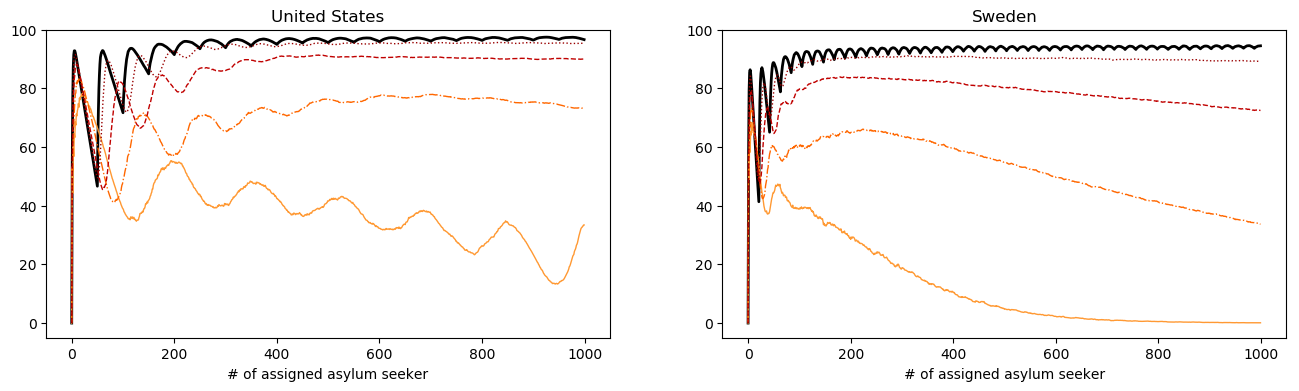

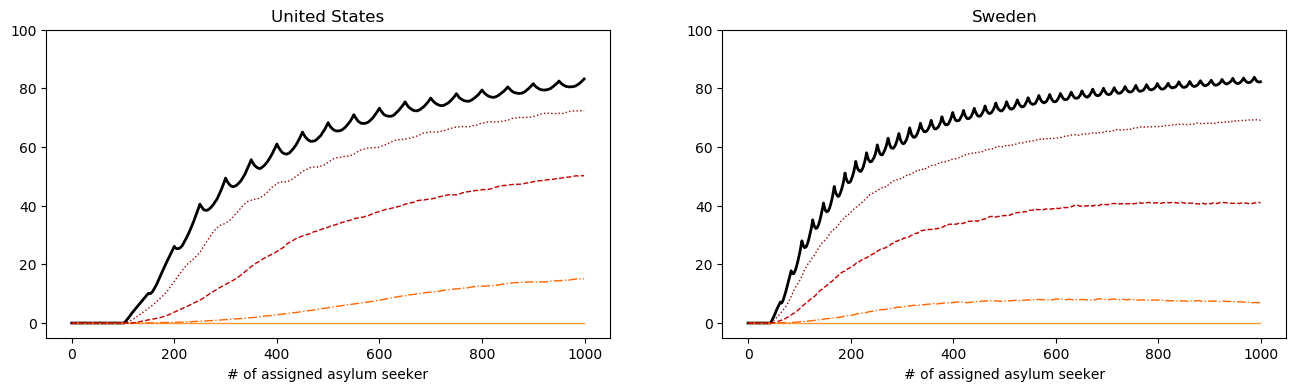

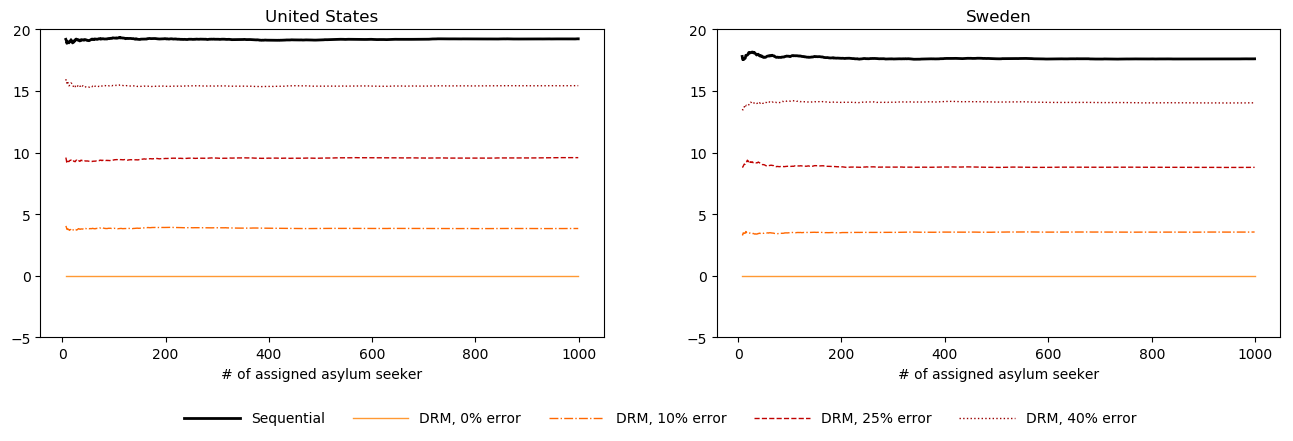

In [7]:
import dynamic_refugee_matching.plot as pltfnc

pltfnc.dynamic_graphs(results, 'envy0', legend=False, saveas='results/graphs/dynamic_envy0.pdf', show=True)
pltfnc.dynamic_graphs(results, 'envy1', legend=False, saveas='results/graphs/dynamic_envy1.pdf', show=True)
pltfnc.dynamic_graphs(results, 'inefficiency', saveas='results/graphs/dynamic_inefficiency.pdf', show=True)

## Sensitivity of quotas to temporal splits

This section shows that ``DRM`` is robust to splitting quotas in smaller temporal intervals. Recall that ``DRM`` allows trasferring information across calls for a dynamic implementation. In this specific setting, we can use this function to assess the effect of resetting information (priority lists, envy matrix) across periods. Allowing for dynamic legacy in a setting with finite quotas allows municipalities to start a period with full capacity and (potentially) positive envy even with no misclassification error in the municipality partitions.

For example, imagine that by chance all the last thousand refugees in a flow are deemed not acceptable by the remaining localities. These ''unlucky'' localities will be worse off, and potentially envy the other localities if these were in the market. Envy legacy allows these potential envies to be carried forth to the next period, where quotas are resetted, and therefore affect the dynamics of the priority and rejection lists.

We begin by setting the parameters for the simulation. In this simulation we only measure outcomes at the end of the refugee flow. We calibrate the refugee flow with Swedish macro data and use 2016 Swedish regional quotas to discipline both ``DRM`` and the sequantial assignment rule. We consider a situation with no error in the municipality partitions and one with 24% misclassification error (Bansak et al., 2018).

In [9]:
## Set parameters
np.random.seed(0)
# Set quotas to 2016 Swedish regional levels
vector_quotas = np.array([180,616,277,213,816,365,697,388,323,894,620,870,2793,347,6904,1031,645,915,532,414,3760])
# rearrange quotas to be divisible by 12
vector_quotas = np.int32(np.round(vector_quotas/12)*12)
n_refugees = np.int(np.sum(vector_quotas))
print('# asylum seekers: ', n_refugees)
# Time splits (year, semester, trimester, month)
splits = [1, 2, 4, 12]

n_simulations = 1
envy1_limit = 5
errorlist = [0, 24]

# Run simulation or load saved results?
run simulation = True

# asylum seekers:  23568


In [ ]:
import dynamic_refugee_matching.simulate as sim
import dynamic_refugee_matching.utilities as utils

if run_simulation is True:
    # Start recording time
    start_time = time.time()

    # Simulate flows and evaluate assignments
    results = sim.simulate_over_quota_splits(vector_quotas, n_simulations, errorlist, envy1_limit)
    utils.save_results(results, 'miscl_errors.pkl')
    
    # Record running time
    elapsed_time = time.time() - start_time
    print('Total running time: ', utils.f_writetime(elapsed_time))
    # utils.print_time('results/runtime_miscl_errors.txt', n_simulations, n_refugees, elapsed_time)
else:
    # Otherwise load saved results
    results = utils.load_results('miscl_errors.pkl')

